In [1]:
import sys; sys.path.append("../src2")
from pendulum import *
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import root

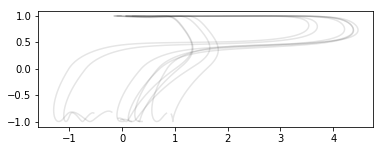

In [18]:
fig, ax = plt.subplots(1)
for i in range(10):
    cont = srinivasan(kx=0.1, kv=0.5, kt=11, kw=10, um=4)
    x0 = [
        np.random.uniform(-0.5, 0.5),
        0,
        np.random.uniform(0.8*np.pi, 1.2*np.pi),
        np.random.uniform(-0.5, 0.5)
    ]
    dyn  = dynamics(x0,[0,0,0,0], 0)
    t, x, u = dyn.propagate_controlled(15, cont)
    plot_traj(x, ax=ax, alpha=0.1, arm=False)

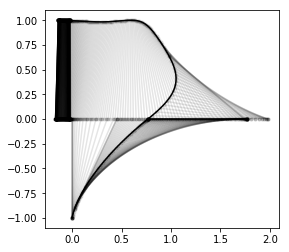

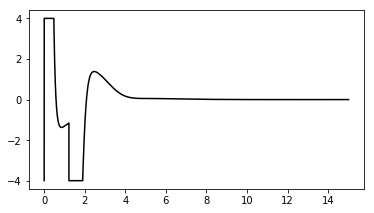

In [19]:
cont = srinivasan(kx=0.1, kv=0.5, kt=11, kw=10, um=4)
x0 = [0,0,np.pi,0]
dyn  = dynamics(x0,[0,0,0,0], 0)
t, x, u = dyn.propagate_controlled(15, cont)
plot_traj(x, arm=True, n=500)
plot_controls(t, u)

In [28]:
def V(state, control):
    x, v, theta, omega = (state[:,i] for i in range(4))
    u = control
    E = omega**2/2 + np.cos(theta) + 1
    dE = -u*omega*np.cos(theta)
    return np.vstack((E, dE)).T

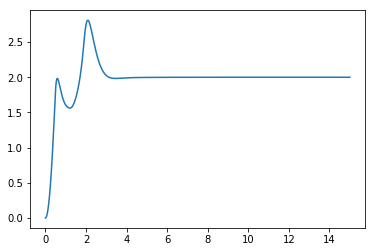

In [29]:
fig, ax = plt.subplots(1)
E = energy(x, u)
ax.plot(t, E[:,0])

In [30]:
x0 = np.array([0,0,np.pi,0])
xf = np.array([0,0,0,0])
dv, feas, t, y, u = solve(x0, xf, 0, dv=[10.24919222,  0.19457643,  0.75414392,  0.96063895,  0.84714559], Tlb=7, Tub=15, atol=1e-8, rtol=1e-8)

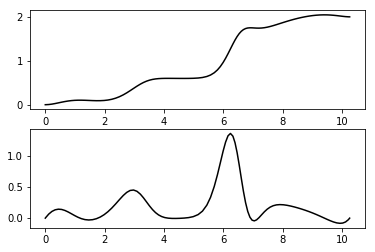

In [41]:
E = energy(y, u)
fig, ax = plt.subplots(2)
E = energy(y, u)
ax[0].plot(t, E[:,0], "k-")
ax[1].plot(t, E[:,1], "k-")